In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.utils import resample

In [36]:
# 2nd cell ................................


# only install the package if it is not already installed
# !pip install ucimlrepo
# !pip install seaborn
from ucimlrepo import fetch_ucirepo 

In [37]:
class LogisticRegression:
    def __init__ (self, lr=0.0001, iter=1000, tol=1e-6):
        self.lr = lr
        self.iter = iter
        self.weights = None
        self.tol = tol
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def update_weights(self, X, y):
        y_pred = self.sigmoid(np.dot(X, self.weights))
        error = y - y_pred
        gradient = np.dot(X.T, error)
        self.weights += self.lr * gradient

    def train(self, X, y):
        n_samples, n_features = X.shape
        X = np.hstack((np.ones((n_samples, 1)), X))
        self.weights = np.zeros(n_features + 1)
        for _ in range(self.iter):
            self.update_weights(X, y)
            
    def predict(self, X, final=True):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        if final:
            return np.round(self.sigmoid(np.dot(X, self.weights)))
        return self.sigmoid(np.dot(X, self.weights))

In [38]:
class Bagging:
    def __init__ (self, base_estimator = LogisticRegression, n_estimators=9, random_state=42, sample_size=0.9):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.sample_size = sample_size
        self.estimators_ = []
    
    def train(self, X, y):
        self.estimators_ = []
        np.random.seed(self.random_state)  
        for _ in range(self.n_estimators):
            estimator = self.base_estimator()
            X_resampled, y_resampled = resample(X, y, n_samples=int(self.sample_size * X.shape[0]))
            estimator.train(X_resampled, y_resampled)
            self.estimators_.append(estimator)
    
    def predict(self, X, final=True):
        predictions = []
        for estimator in self.estimators_:
            predictions.append(estimator.predict(X, final))
        predictions = np.array(predictions)
        return predictions
    
    def predict_majority(self, X, final=True):
        predictions = self.predict(X, final)
        majority_votes = []
        for i in range(predictions.shape[1]):
            feature_predictions = predictions[:, i].astype(int)
            majority_vote = np.argmax(np.bincount(feature_predictions))
            majority_votes.append(majority_vote)
        return np.array(majority_votes)
    
    def predict_prob(self, X):
        predictions = self.predict(X, final=False)
        return np.mean(predictions, axis=0)

In [39]:
class Stacking:
    def __init__ (self, base_estimator = LogisticRegression, meta_estimator= LogisticRegression):
        self.base_estimators = base_estimator
        self.meta_estimator = meta_estimator
        self.meta_model = None
        self.base_models = None

    def train(self, X, y, X_meta, y_meta):
        self.base_models = Bagging(self.base_estimators, n_estimators=9)
        self.base_models.train(X, y)
        meta_samples = self.base_models.predict(X_meta, False).T
        meta_samples = np.hstack([ X_meta , meta_samples])
        self.meta_model = self.meta_estimator()
        self.meta_model.train(meta_samples, y_meta)

    def predict(self, X, final=True):
        meta_samples = self.base_models.predict(X, False).T
        meta_samples = np.hstack([X, meta_samples])
        prediction = self.meta_model.predict(meta_samples, final)
        return prediction

In [40]:
# 6th cell ................................


def scaling(scalingmethod):
    if scalingmethod == 'minmax':
        return MinMaxScaler()
    elif scalingmethod == 'standard':
        return StandardScaler()
    else:
        raise ValueError("Invalid scaling method. Choose 'minmax' or 'standard'.")

scaler = scaling('minmax')

## Choose only one dataset to work with

### Function for Dataset One

In [41]:
def getDataSetOne():
    dataframe = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
    dataframe.drop(columns='customerID', inplace=True)
    dataframe.drop_duplicates(inplace=True)

    features = dataframe.drop('Churn', axis=1)
    labels = dataframe['Churn']

    # Step 1: Remove leading/trailing spaces
    features['TotalCharges'] = features['TotalCharges'].str.strip()
    # Step 2: Remove any non-numeric characters (except for the decimal point)
    features['TotalCharges'] = features['TotalCharges'].str.replace(r'[^\d.]+', '', regex=True)
    # Step 3: Convert to numeric, coercing errors to NaN
    features['TotalCharges'] = pd.to_numeric(features['TotalCharges'], errors='coerce')
    # Step 4: Calculate the mean of the column, ignoring NaN values
    mean_total_charges = features['TotalCharges'].mean()
    # Step 5: Replace NaN values with the calculated mean

    features['TotalCharges'].fillna(mean_total_charges, inplace=True)
    numeric_collums = features.select_dtypes(include=['number']).columns

    encoder = LabelEncoder()
    for column in features.columns:
        unique_values = features[column].unique()
        if len(unique_values) == 2:
            features[column] = encoder.fit_transform(features[column])
    labels = encoder.fit_transform(labels)
    labels = pd.Series(labels)
    non_numeric_columns = features.select_dtypes(exclude=['number']).columns
    for col in non_numeric_columns:
        features[col] = features[col].astype('category')
    features = pd.get_dummies(features)
    for column in features.select_dtypes(include=['bool']).columns:
        features[column] = features[column].astype(int)
    return features, labels, numeric_collums

### Function for Dataset Two

In [42]:
def getDataSetTwo():
    adult = fetch_ucirepo(id=2) 
    X = adult.data.features 
    y = adult.data.targets 

    numeric_collums = X.select_dtypes(include=['number']).columns

    encoder = LabelEncoder()
    X['sex'] = encoder.fit_transform(X['sex'])
    y['income'] = y['income'].replace({"<=50K": 0, "<=50K.": 0, ">50K": 1, ">50K.": 1})
    y['income'] = y['income'].astype(int)
    y = y.to_numpy().ravel()
    y = pd.Series(y)

    object_columns = X.select_dtypes(include=['object']).columns

    for column in X.columns:
        if X[column].isnull().any():
            mode_value = X[column].mode()[0]
            X[column].fillna(mode_value, inplace=True)

    for col in object_columns:
        X[col] = X[col].astype('category')

    X = pd.get_dummies(X)
    if X.select_dtypes(include=['bool']).any().any():
        X = X.astype('int64')

    return X, y, numeric_collums

### Function for Dataset Three

In [43]:
def getDataSetThree():
    dataframe = pd.read_csv("creditcard.csv")
    dataframe.drop_duplicates(inplace=True)
    negative = dataframe[dataframe["Class"] == 0]
    postive = dataframe[dataframe["Class"] == 1]

    negative_sampled = negative.sample(n = 20000, random_state=42)
    all_sampled = pd.concat([negative_sampled, postive])

    dataframe = all_sampled.sample(frac=1).reset_index(drop=True)
    numeric_collums = ['Time', 'Amount']
    features = dataframe.drop('Class', axis=1)
    labels = dataframe['Class']
    
    return features, labels, numeric_collums

In [44]:
def getDataSet(num):
    if num == 1:
        return getDataSetOne()
    elif num == 2:
        return getDataSetTwo()
    elif num == 3:
        return getDataSetThree()

#### For first dataset set Parameter of getDataset to 1, for Second dataset 2 and for third dataset 3.

In [45]:
# 11th cell ................................

# for first dataset 1
# for second dataset 2
# for third dataset 3
features, labels, numeric_collums = getDataSet(1)

C:\Users\Excalibur\AppData\Local\Temp\ipykernel_14372\3361114007.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features['TotalCharges'].fillna(mean_total_charges, inplace=True)


#### for first dataset set parameter of nlargest function to 20, for second set 30 and for third set 20

In [46]:
# 12th cell ................................

to_scale_features = features[numeric_collums]
scaled_features = scaler.fit_transform(to_scale_features)
features[numeric_collums] = scaled_features

stddev = features.std()
zero_stdev = stddev[stddev == 0].index
features_correlations = features.drop(zero_stdev, axis=1)

correlations = features_correlations.corrwith(labels)
correlations = correlations.abs()
# for first dataset set 20
# for second dataset set 30
# for third dataset set 20
correlations = correlations.nlargest(20)

features = features[correlations.index]

## Logistic Regression 

In [47]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

clf = LogisticRegression()
clf.train(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict(X_test, False)

accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_prob)
aupr = average_precision_score(y_test, y_pred_prob)

print(f"Accuracy of Logistic Regression classifier: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUROC: {auroc:.4f}")
print(f"AUPR: {aupr:.4f}")

Accuracy of Logistic Regression classifier: 0.7943
Sensitivity (Recall): 0.5227
Specificity: 0.8851
Precision: 0.6033
F1-score: 0.5601
AUROC: 0.8446
AUPR: 0.6131


## Majority Voting

In [48]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

clf = Bagging()
clf.train(X_train, y_train)
y_pred = clf.predict_majority(X_test)
y_pred_prob = clf.predict_prob(X_test)

majority_accuracy = accuracy_score(y_test, y_pred)
majority_sensitivity = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
majority_specificity = tn / (tn + fp)
majority_precision = precision_score(y_test, y_pred)
majority_f1 = f1_score(y_test, y_pred)
majority_auroc = roc_auc_score(y_test, y_pred_prob)
majority_aupr = average_precision_score(y_test, y_pred_prob)

## Violin Plot

<Axes: xlabel='Metrics', ylabel='Model Performance'>

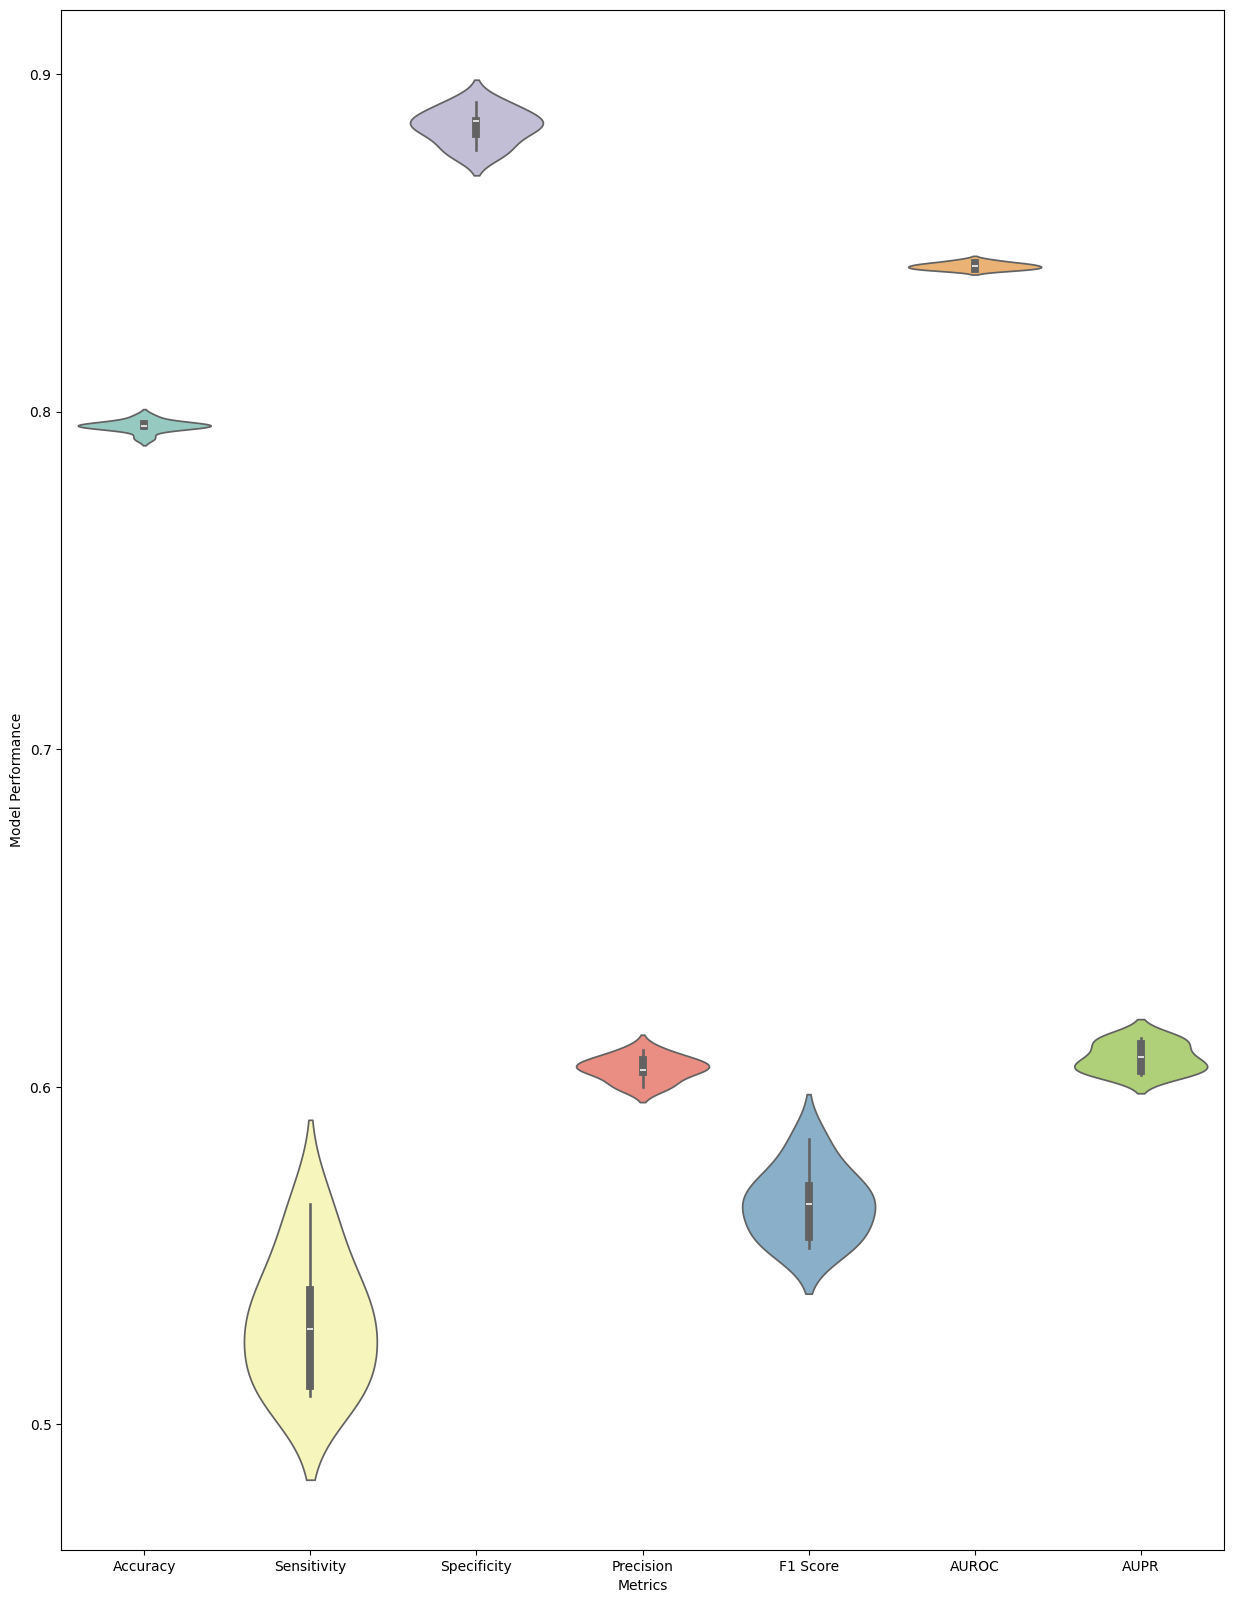

In [49]:
import seaborn as sns
tips_prob = clf.predict(X_test, False)
tips_rounded = clf.predict(X_test)
accuracies = []
sensitivities= []
specificities = []
precisions = []
f1_s = []
auroc_s = []
aupr_s = []
for i in range(tips_rounded.shape[0]):
    accuracies.append(accuracy_score(y_test, tips_rounded[i]))
    sensitivities.append(recall_score(y_test, tips_rounded[i]))
    tn, fp, fn, tp = confusion_matrix(y_test, tips_rounded[i]).ravel()
    specificities.append(tn / (tn + fp))
    precisions.append(precision_score(y_test, tips_rounded[i]))
    f1_s.append(f1_score(y_test, tips_rounded[i]))
    auroc_s.append(roc_auc_score(y_test, tips_prob[i]))
    aupr_s.append(average_precision_score(y_test, tips_prob[i]))

tips = np.array([accuracies, sensitivities, specificities, precisions, f1_s, auroc_s, aupr_s]).T  
tips = pd.DataFrame(tips, columns=['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score', 'AUROC', 'AUPR'])
tips = tips.melt(var_name='Metrics', value_name='Model Performance')
plt.figure(figsize=(15, 20))
sns.violinplot(x="Metrics", y="Model Performance", data=tips, hue="Metrics", palette="Set3", legend=False)

## Emsemble Learning / Stacking

In [50]:

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
X_train, X_meta, y_train, y_meta = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()
y_meta = y_meta.to_numpy().ravel()

clf = Stacking()
clf.train(X_train, y_train, X_meta, y_meta)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict(X_test, False)

stacking_accuracy = accuracy_score(y_test, y_pred)
stacking_sensitivity = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
stacking_specificity = tn / (tn + fp)
stacking_precision = precision_score(y_test, y_pred)
stacking_f1 = f1_score(y_test, y_pred)
stacking_auroc = roc_auc_score(y_test, y_pred_prob)
stacking_aupr = average_precision_score(y_test, y_pred_prob)

## Tabular Result

In [51]:
from tabulate import tabulate

table = {
    ' ': ['LR*', 'Voting ensemble', 'Stacking ensemble'],
    'Accuracy': [f'{np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}', f'{majority_accuracy:.4f}', f'{stacking_accuracy:.4f}'],
    'Sensitivity': [f'{np.mean(sensitivities):.4f} ± {np.std(sensitivities):.4f}', f'{majority_sensitivity:.4f}', f'{stacking_sensitivity:.4f}'],
    'Specificity': [f'{np.mean(specificities):.4f} ± {np.std(specificities):.4f}', f'{majority_specificity:.4f}', f'{stacking_specificity:.4f}'],
    'Precision': [f'{np.mean(precisions):.4f} ± {np.std(precisions):.4f}', f'{majority_precision:.4f}', f'{stacking_precision:.4f}'],
    'F1-score': [f'{np.mean(f1_s):.4f} ± {np.std(f1_s):.4f}', f'{majority_f1:.4f}', f'{stacking_f1:.4f}'],
    'AUROC': [f'{np.mean(auroc_s):.4f} ± {np.std(auroc_s):.4f}', f'{majority_auroc:.4f}', f'{stacking_auroc:.4f}'],
    'AUPR': [f'{np.mean(aupr_s):.4f} ± {np.std(aupr_s):.4f}', f'{majority_aupr:.4f}', f'{stacking_aupr:.4f}']
}

table = pd.DataFrame(table)

print(tabulate(table, headers='keys', tablefmt='pretty'))


+---+-------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|   |                   |    Accuracy     |   Sensitivity   |   Specificity   |    Precision    |    F1-score     |      AUROC      |      AUPR       |
+---+-------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| 0 |        LR*        | 0.7957 ± 0.0016 | 0.5306 ± 0.0182 | 0.8844 ± 0.0048 | 0.6054 ± 0.0033 | 0.5654 ± 0.0098 | 0.8431 ± 0.0009 | 0.6087 ± 0.0040 |
| 1 |  Voting ensemble  |     0.7929      |     0.5256      |     0.8822      |     0.5987      |     0.5598      |     0.8440      |     0.6084      |
| 2 | Stacking ensemble |     0.7950      |     0.5511      |     0.8765      |     0.5988      |     0.5740      |     0.8344      |     0.5974      |
+---+-------------------+-----------------+-----------------+-----------------+---------